# Arkhamdb Investigator Popularity Racing Bar Chart
Created: 2021-11-02  
Updated: 2021-11-15  
Author: Spencer Simon

## Overview

This notebook uses data downloaded from [arkhamdb.com](https://arkhamdb.com) using their [public api](https://arkhamdb.com/api/).  The data downloading and cleaning is performed in the arkhamdb-data repository. 

This data is transformed and used to create a racing bar chart of investigator popularity over time in this notebook.  

## Setup

### Install and import libraries

In [50]:
#import sys
#!{sys.executable} -m pip install git+https://github.com/programiz/bar_chart_race.git@master --user
#!{sys.executable} -m pip install openpyxl --user

In [2]:
import pandas as pd
from datetime import datetime
import bar_chart_race as bcr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pd.set_option('display.max_columns', 50)

### Load Data

In [4]:
df = pd.read_csv('../arkhamdb-data/investigator_popularity_raw.csv')

In [5]:
df.head()

,id,name,date_creation,investigator_code,investigator_name,create_year,create_month,create_day
0,1,Roland Banks Starter Deck,2016-09-02 13:17:02,1001,Roland Banks,2016,9,2
1,2,Wendy Adams Starter Deck,2016-09-02 13:18:34,1005,Wendy Adams,2016,9,2
2,3,I'm Half Crazy,2016-10-12 07:59:47,1002,Daisy Walker,2016,10,12
3,4,"Roland Banks, Just a G-Man",2016-10-12 16:50:58,1001,Roland Banks,2016,10,12
4,6,Orphan's First deck,2016-10-15 22:39:06,1005,Wendy Adams,2016,10,15


In [6]:
df.shape

(30235, 8)

## Data Preparation

### Drop duplicate decks

In [7]:
df_temp = df.drop_duplicates(
    subset = ['name', 'date_creation'],
    keep = 'last').reset_index(drop = True)

In [8]:
df_temp.shape

(19878, 8)

In [9]:
print(f"Number of duplicate decks dropped: {df.shape[0] - df_temp.shape[0]}")

Number of duplicate decks dropped: 10357


### Create date only field (without time), and date2 with only year-month

In [10]:
df_temp['date'] = pd.to_datetime(df_temp['date_creation']).dt.date

In [11]:
df_temp['date2'] = pd.to_datetime(df_temp['date_creation']).dt.date.apply(lambda x: x.strftime('%Y-%m'))

In [12]:
df_temp.head()

,id,name,date_creation,investigator_code,investigator_name,create_year,create_month,create_day,date,date2
0,1,Roland Banks Starter Deck,2016-09-02 13:17:02,1001,Roland Banks,2016,9,2,2016-09-02,2016-09
1,2,Wendy Adams Starter Deck,2016-09-02 13:18:34,1005,Wendy Adams,2016,9,2,2016-09-02,2016-09
2,3,I'm Half Crazy,2016-10-12 07:59:47,1002,Daisy Walker,2016,10,12,2016-10-12,2016-10
3,4,"Roland Banks, Just a G-Man",2016-10-12 16:50:58,1001,Roland Banks,2016,10,12,2016-10-12,2016-10
4,6,Orphan's First deck,2016-10-15 22:39:06,1005,Wendy Adams,2016,10,15,2016-10-15,2016-10


### Drop all fields except investigator name and date

In [13]:
df_small = df_temp[["date", "investigator_name"]]
df_small2 = df_temp[["date2", "investigator_name"]]

In [14]:
df_small.head()

,date,investigator_name
0,2016-09-02,Roland Banks
1,2016-09-02,Wendy Adams
2,2016-10-12,Daisy Walker
3,2016-10-12,Roland Banks
4,2016-10-15,Wendy Adams


### Get count of decks built per investigator per day

In [15]:
counts_series = df_small.groupby(['date', 'investigator_name']).size()
df_counts = counts_series.to_frame(name = 'count').reset_index()

counts_series2 = df_small2.groupby(['date2', 'investigator_name']).size()
df_counts2 = counts_series2.to_frame(name = 'count').reset_index()

In [16]:
#df_counts.tail()
df_counts2.tail()

,date2,investigator_name,count
1702,2021-10,Ursula Downs,4
1703,2021-10,Wendy Adams,10
1704,2021-10,William Yorick,15
1705,2021-10,Winifred Habbamock,4
1706,2021-10,Zoey Samaras,21


### Pivot df to wide format

In [17]:
df_wide = pd.pivot_table(df_counts, values='count', index = 'date', 
                         columns = ['investigator_name'], aggfunc=np.sum, fill_value=0)

df_wide2 = pd.pivot_table(df_counts2, values='count', index = 'date2', 
                         columns = ['investigator_name'], aggfunc=np.sum, fill_value=0)

In [18]:
df_wide2*12

investigator_name,"""Ashcan"" Pete","""Skids"" O'Toole",Agnes Baker,Akachi Onyele,Amanda Sharpe,Bob Jenkins,Calvin Wright,Carolyn Fern,Daisy Walker,Daniela Reyes,Dexter Drake,Diana Stanley,Father Mateo,Finn Edwards,Gloria Goldberg,Harvey Walters,Jacqueline Fine,Jenny Barnes,Jim Culver,Joe Diamond,Leo Anderson,Lily Chen,Lola Hayes,Luke Robinson,Mandy Thompson,Marie Lambeau,Mark Harrigan,Minh Thi Phan,Monterey Jack,Nathaniel Cho,Norman Withers,Patrice Hathaway,Preston Fairmont,Rex Murphy,Rita Young,Roland Banks,Sefina Rousseau,Silas Marsh,Sister Mary,Stella Clark,Tommy Muldoon,Tony Morgan,Trish Scarborough,Ursula Downs,Wendy Adams,William Yorick,Winifred Habbamock,Zoey Samaras
date2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,12,0,0,0
2016-10,0,60,24,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,72,0,0,0
2016-11,0,168,276,0,0,0,0,0,204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,372,0,0,0,0,0,0,0,0,288,0,0,0
2016-12,0,240,168,0,0,0,0,0,216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,204,0,0,0,0,0,0,0,0,228,0,0,0
2017-01,348,144,132,0,0,0,0,0,156,0,0,0,0,0,0,0,0,300,132,0,0,0,0,0,0,12,0,0,0,0,0,0,0,180,0,192,0,0,0,0,0,0,0,0,132,0,0,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06,108,96,96,108,96,0,48,144,84,0,36,84,72,60,48,108,84,132,12,204,180,0,24,48,48,48,204,48,0,144,0,12,72,132,36,132,108,36,36,72,60,108,60,168,96,120,48,144
2021-07,120,108,72,180,48,12,96,60,228,0,120,108,36,48,24,72,48,96,60,144,144,12,24,72,36,36,144,48,0,12,72,84,48,132,36,192,72,180,24,24,72,60,132,108,48,84,24,300
2021-08,180,180,204,120,84,12,84,72,168,0,96,84,72,72,12,60,96,156,36,156,36,0,24,84,48,12,12,60,12,60,72,24,96,132,48,144,24,120,24,60,48,60,108,144,60,120,36,168


### Add in rows for missing dates

In [19]:
# New index range is min to max date
new_index = pd.date_range(df_wide.index.min(), df_wide.index.max()) 
df_wide = df_wide.reindex(new_index, fill_value=0)

In [20]:
df_wide

investigator_name,"""Ashcan"" Pete","""Skids"" O'Toole",Agnes Baker,Akachi Onyele,Amanda Sharpe,Bob Jenkins,Calvin Wright,Carolyn Fern,Daisy Walker,Daniela Reyes,Dexter Drake,Diana Stanley,Father Mateo,Finn Edwards,Gloria Goldberg,Harvey Walters,Jacqueline Fine,Jenny Barnes,Jim Culver,Joe Diamond,Leo Anderson,Lily Chen,Lola Hayes,Luke Robinson,Mandy Thompson,Marie Lambeau,Mark Harrigan,Minh Thi Phan,Monterey Jack,Nathaniel Cho,Norman Withers,Patrice Hathaway,Preston Fairmont,Rex Murphy,Rita Young,Roland Banks,Sefina Rousseau,Silas Marsh,Sister Mary,Stella Clark,Tommy Muldoon,Tony Morgan,Trish Scarborough,Ursula Downs,Wendy Adams,William Yorick,Winifred Habbamock,Zoey Samaras
2016-09-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2016-09-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-09-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0,2,0,0,0,0,0,0,1,0,0,0,0,1
2021-10-28,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2021-10-29,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,1
2021-10-30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


### Calculate rolling sums
For 1st df, Use 30 days as an approximation for the month and 90 days for 3 months  
For df2, get 3 month and 6 month sums

In [20]:
df_sums_30d = df_wide.copy()
cols=list(df_wide.columns)

df_sums_30d[pd.Index(cols)] = df_wide[cols].rolling(window=30).sum()

In [21]:
df_sums_3m = df_wide2.copy()
cols=list(df_wide2.columns)

df_sums_3m[pd.Index(cols)] = df_wide2[cols].rolling(window=3).sum()

In [22]:
# Calculate 90 day sums
df_sums_90d = df_wide.copy()
df_sums_90d[pd.Index(cols)] = df_wide[cols].rolling(window=90).sum()

In [23]:
# Calculate 6 month sums
df_sums_6m = df_wide2.copy()
df_sums_6m[pd.Index(cols)] = df_wide2[cols].rolling(window=6, min_periods=3).sum()

In [24]:
df_sums_6m[2:]*2

investigator_name,"""Ashcan"" Pete","""Skids"" O'Toole",Agnes Baker,Akachi Onyele,Amanda Sharpe,Bob Jenkins,Calvin Wright,Carolyn Fern,Daisy Walker,Daniela Reyes,Dexter Drake,Diana Stanley,Father Mateo,Finn Edwards,Gloria Goldberg,Harvey Walters,Jacqueline Fine,Jenny Barnes,Jim Culver,Joe Diamond,Leo Anderson,Lily Chen,Lola Hayes,Luke Robinson,Mandy Thompson,Marie Lambeau,Mark Harrigan,Minh Thi Phan,Monterey Jack,Nathaniel Cho,Norman Withers,Patrice Hathaway,Preston Fairmont,Rex Murphy,Rita Young,Roland Banks,Sefina Rousseau,Silas Marsh,Sister Mary,Stella Clark,Tommy Muldoon,Tony Morgan,Trish Scarborough,Ursula Downs,Wendy Adams,William Yorick,Winifred Habbamock,Zoey Samaras
date2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-11,0.0,38.0,50.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,0.0,0.0
2016-12,0.0,78.0,78.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2017-01,58.0,102.0,100.0,0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,0.0,46.0
2017-02,100.0,114.0,120.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0,90.0
2017-03,146.0,136.0,160.0,0.0,0.0,0.0,0.0,0.0,176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.0,0.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,0.0,140.0
2017-04,180.0,142.0,176.0,0.0,0.0,0.0,0.0,0.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,0.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,0.0,202.0
2017-05,204.0,134.0,164.0,0.0,0.0,0.0,0.0,0.0,174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0,0.0,0.0,240.0
2017-06,228.0,128.0,178.0,0.0,0.0,0.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,228.0,0.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.0,0.0,0.0,270.0
2017-07,214.0,136.0,192.0,0.0,0.0,0.0,0.0,0.0,176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,304.0,158.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.0,304.0


## Export data files

In [44]:
df_day_export = df_wide.copy()
df_month_export = df_wide2.copy()

In [45]:
df_month_export.index = pd.to_datetime(df_month_export.index).strftime('%b, %Y')

In [46]:
df_day_export = df_day_export.transpose()
df_month_export = df_month_export.transpose()

In [47]:
df_month_export.head()

date2,"Sep, 2016","Oct, 2016","Nov, 2016","Dec, 2016","Jan, 2017","Feb, 2017","Mar, 2017","Apr, 2017","May, 2017","Jun, 2017","Jul, 2017","Aug, 2017","Sep, 2017","Oct, 2017","Nov, 2017","Dec, 2017","Jan, 2018","Feb, 2018","Mar, 2018","Apr, 2018","May, 2018","Jun, 2018","Jul, 2018","Aug, 2018","Sep, 2018",...,"Oct, 2019","Nov, 2019","Dec, 2019","Jan, 2020","Feb, 2020","Mar, 2020","Apr, 2020","May, 2020","Jun, 2020","Jul, 2020","Aug, 2020","Sep, 2020","Oct, 2020","Nov, 2020","Dec, 2020","Jan, 2021","Feb, 2021","Mar, 2021","Apr, 2021","May, 2021","Jun, 2021","Jul, 2021","Aug, 2021","Sep, 2021","Oct, 2021"
investigator_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Ashcan"" Pete",0,0,0,0,29,21,23,17,12,12,22,19,19,14,15,11,23,9,19,18,14,20,13,21,16,...,21,19,15,13,13,32,53,21,17,15,18,12,17,14,17,13,12,21,12,10,9,10,15,9,14
"""Skids"" O'Toole",0,5,14,20,12,6,11,8,10,17,16,7,8,6,10,2,9,10,3,8,5,6,4,12,5,...,7,6,5,12,6,12,34,16,8,8,23,12,15,10,13,4,13,15,6,10,8,9,15,7,5
Agnes Baker,0,2,23,14,11,10,20,10,17,21,18,27,18,17,7,3,16,5,7,11,6,8,6,7,3,...,14,10,8,8,7,30,50,27,18,13,6,10,14,19,12,12,17,15,14,17,8,6,17,12,19
Akachi Onyele,0,0,0,0,0,0,0,0,0,0,0,0,15,20,11,6,8,5,5,7,13,11,13,7,8,...,15,12,10,11,6,12,24,18,9,4,6,6,3,6,3,8,6,11,5,4,9,15,10,4,4
Amanda Sharpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,17,11,14,4,3,6,1,6,8,4,7,2,5


In [51]:
df_day_export.to_excel('data/day_counts.xlsx')
df_month_export.to_excel('data/month_counts.xlsx')

## Initial Visualizations

### Time series of number of decks created
Based on https://www.python-graph-gallery.com/web-line-chart-with-labels-at-line-end

In [25]:
df_ts = df_counts2.copy()

In [26]:
df_ts['date'] = pd.to_datetime(df_ts['date2'])

In [27]:
df_ts.head()

,date2,investigator_name,count,date
0,2016-09,Roland Banks,1,2016-09-01
1,2016-09,Wendy Adams,1,2016-09-01
2,2016-10,"""Skids"" O'Toole",5,2016-10-01
3,2016-10,Agnes Baker,2,2016-10-01
4,2016-10,Daisy Walker,3,2016-10-01


In [28]:
# A list of investigators that are going to be highlighted
HIGHLIGHTS = ["Zoey Samaras", "Roland Banks", "Jenny Barnes"]

In [29]:
# Create 'group' to determine which ones are highlighted
df_ts["group"] = np.where(
    df_ts["investigator_name"].isin(HIGHLIGHTS),
    df_ts["investigator_name"],
    "other"
)

# Make 'group' categorical 
df_ts["group"] = pd.Categorical(
    df_ts["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [30]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
    GREY50     # USA
]

# Vertical lines every 5 years
VLINES = np.arange(2016, 2021, 1)

(17045.0, 18901.0)

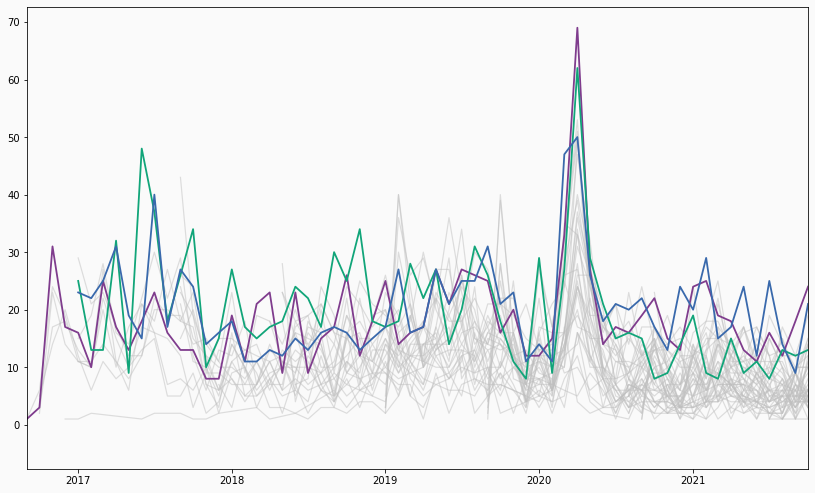

In [31]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
#for h in VLINES:
#    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(-4, 4), xmin=2016, xmax=2021, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2016, xmax=2021, color=GREY60, lw=0.8)

# Vertical like at x = 2008
#ax.axvline(2018, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
#ax.text(2018.15, -3.35, "2018", fontname="Montserrat", 
#        fontsize=14, fontweight=500, color=GREY40, ha="left")

# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = df_ts[df_ts["group"] != "other"]
df_others = df_ts[df_ts["group"] == "other"]

for group in df_others["investigator_name"].unique():
    data = df_others[df_others["investigator_name"] == group]
    ax.plot("date", "count", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["investigator_name"].unique()):
    data = df_highlight[df_highlight["investigator_name"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("date", "count", color=color, lw=1.8, data=data)
    
ax.set_xlim([datetime(2016, 9, 1), datetime(2021, 10, 1)])

In [32]:
#datetime.date(2014, 1, 26)

## Create Racing Bar Chart

Updates:
- Make df with only the rolling sums
- Make col names of this new df just investigator names
- decide on if 30 day sums are best measure
- Make bcr with options: images, top X bars, colors, etc.

In [38]:
# Test with monthly data * 12
bcr.bar_chart_race(
    df=df_wide2*12,
    img_label_folder='images',
    filename='test.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    #fixed_max=True,
    steps_per_period=45,
    interpolate_period=True,
    label_bars=True,
    bar_size=.95,
    #period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    #period_fmt='%B %d, %Y',
    #period_summary_func=lambda v, r: {'x': .99, 'y': .18,
    #                                  's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
    #                                  'ha': 'right', 'size': 8, 'family': 'Courier New'},
    #perpendicular_bar_func='median',
    period_length=1500,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Investigator Popularity',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)

TypeError: bar_chart_race() got an unexpected keyword argument 'img_label_folder'

In [ ]:
# OLD: chart with daily period
bcr.bar_chart_race(
    df=df_wide_sums[1500:1550],
    filename=None,
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    #period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    #period_summary_func=lambda v, r: {'x': .99, 'y': .18,
    #                                  's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
    #                                  'ha': 'right', 'size': 8, 'family': 'Courier New'},
    #perpendicular_bar_func='median',
    period_length=200,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Investigator Popularity',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)

In [34]:
# Test with monthly (6 month) data multiplied by 2 (decks per year)
bcr.bar_chart_race(
    df=df_sums_6m[2:]*2,
    filename=None,
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    #fixed_max=True,
    steps_per_period=30,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    #period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    #period_fmt='%B %d, %Y',
    #period_summary_func=lambda v, r: {'x': .99, 'y': .18,
    #                                  's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
    #                                  'ha': 'right', 'size': 8, 'family': 'Courier New'},
    #perpendicular_bar_func='median',
    period_length=1000,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Investigator Popularity',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)

/Users/spencersimon/Library/Python/3.7/lib/python/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/Users/spencersimon/Library/Python/3.7/lib/python/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/Users/spencersimon/Library/Python/3.7/lib/python/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


Exception: You do not have ffmpeg installed on your machine. Download
                            ffmpeg from here: https://www.ffmpeg.org/download.html.
                            
                            Matplotlib's original error message below:

                            Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '838x432', '-pix_fmt', 'rgba', '-r', '29.999999999999996', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/rp/ycl7ptqj3593hmqd_87rn_jw0000gn/T/tmpedoo3y3d/temp.m4v']' returned non-zero exit status 255.
                            

In [ ]:
# Do like above, with 1 month numbers * 12
# Try Percentages

In [ ]:
# Example from documentation

bcr.bar_chart_race(
    df=df_wide,
    filename='covid19_horiz.mp4',
    orientation='h',
    sort='desc',
    n_bars=6,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%B %d, %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Total deaths: {v.nlargest(6).sum():,.0f}',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=500,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='COVID-19 Deaths by Country',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)